In [1]:
from geopandas.tools import sjoin
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys


In [2]:
#import libraries from local directory 

from climada.hazard import Centroids, TropCyclone,TCTracks
from climada.hazard.tc_tracks import estimate_roci,estimate_rmw
from climada.hazard.tc_tracks_forecast import TCForecast


2021-04-23 12:23:56,680 - climada - DEBUG - Loading default config file: C:\Users\ATeklesadik\OneDrive - Rode Kruis\Documents\documents\Typhoon-Impact-based-forecasting-model\lib\climada\conf\defaults.conf


In [ ]:
#define functions 

In [3]:
def adjust_tracks(forcast_df):
    track = xr.Dataset(
        data_vars={
            'max_sustained_wind': ('time', (1.94384/0.84)*forcast_df.max_sustained_wind.values),
            'environmental_pressure': ('time', forcast_df.environmental_pressure.values),
            'central_pressure': ('time', forcast_df.central_pressure.values),
            'lat': ('time', forcast_df.lat.values),
            'lon': ('time', forcast_df.lon.values),
            'radius_max_wind':('time', estimate_rmw(forcast_df.radius_max_wind.values, forcast_df.central_pressure.values)),  
            'radius_oci':('time', estimate_roci(forcast_df.radius_max_wind.values, forcast_df.central_pressure.values)), 
            'time_step':('time', forcast_df.time_step.values),
        },
        coords={
            'time': forcast_df.time.values,
        },
        attrs={
            'max_sustained_wind_unit': 'kn',
            'central_pressure_unit': 'mb',
            'name': forcast_df.name,
            'sid': forcast_df.sid+str(forcast_df.ensemble_number),
            'orig_event_flag': True,#forcast_df.orig_event_flag,
            'data_provider': forcast_df.data_provider,
            'id_no': forcast_df.id_no,
            'ensemble_number': forcast_df.ensemble_number,
            'is_ensemble':forcast_df.is_ensemble,
            'forecast_time': forcast_df.forecast_time,
            'basin': forcast_df.basin,
            'category': forcast_df.category,
        }
    )
    track = track.set_coords(['lat', 'lon'])
    return track

In [ ]:
# download example file ,remote_dir should be set to None to dwnload operational data 

In [4]:
remote_dir='20210416000000' #None

In [5]:

bufr_files = TCForecast.fetch_bufr_ftp(remote_dir=remote_dir)
fcast = TCForecast()
fcast.fetch_ecmwf(files=bufr_files)


2021-04-23 12:24:08,891 - climada.hazard.tc_tracks_forecast - INFO - Fetching BUFR tracks:


Processing: 100%|███████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.47files/s]


In [6]:

# filter tracks with name of current typhoon
typhoon_name='SURIGAE'
 
fcast.data = [tr for tr in fcast.data if tr.name==typhoon_name]

# drop tracks with only one timestep
fcast.data = [tr for tr in fcast.data if tr.time.size>1]


binding_box=[[min(tr.lat.values),
              max(tr.lat.values),
              min(tr.lon.values),
              max(tr.lon.values)] for tr in fcast.data if tr.is_ensemble==False][0]



fcast.data = [adjust_tracks(tr) for tr in fcast.data]
# interpolate to 3h steps from the original 6h
fcast.equal_timestep(3)

# construct centroids
#min_lat, max_lat, min_lon, max_lon = 12.0, 16.0, 120, 125
min_lat, max_lat, min_lon, max_lon = binding_box[0], binding_box[1], binding_box[2]-.5, binding_box[3]
cent = Centroids()
cent.set_raster_from_pnt_bounds((max([min_lon,117]), max([min_lat,5]), min([max_lon,128]), min([max_lat,22])), res=0.1)
cent.check()

2021-04-23 12:24:26,495 - climada.hazard.tc_tracks - INFO - Interpolating 53 tracks to 3h time steps.


C:\Users\ATeklesadik\OneDrive - Rode Kruis\Documents\documents\Typhoon-Impact-based-forecasting-model\lib\climada\util\plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


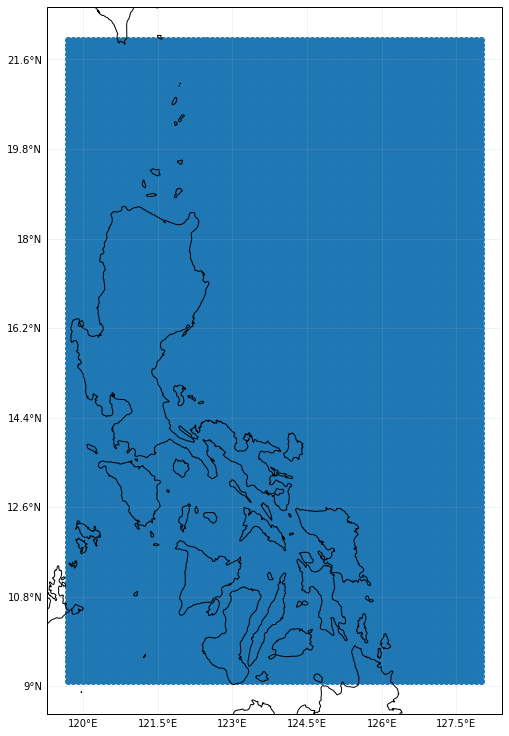

In [7]:
cent.plot()

In [8]:
threshold=0
df = pd.DataFrame(data=cent.coord)
df["centroid_id"] = "id"+(df.index).astype(str)  
centroid_idx=df["centroid_id"].values
ncents = cent.size
df=df.rename(columns={0: "lat", 1: "lon"})

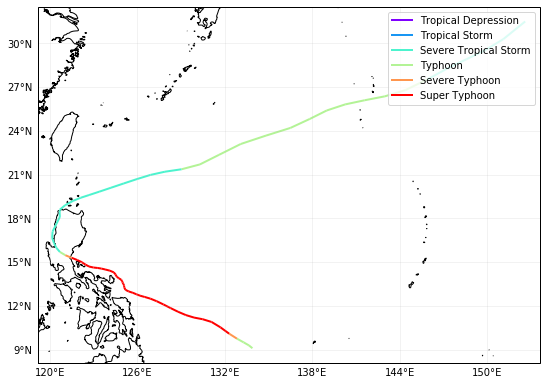

In [9]:
track = TCTracks() 
track.data=[fcast.data[0]]
track.plot()

In [10]:
typhoon = TropCyclone()
typhoon.set_from_tracks(track, cent, store_windfields=True)


2021-04-23 12:25:07,717 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2021-04-23 12:25:09,299 - climada.util.coordinates - INFO - dist_to_coast: UTM 32650 (1/3)
2021-04-23 12:25:10,617 - climada.util.coordinates - INFO - dist_to_coast: UTM 32651 (2/3)
2021-04-23 12:25:13,820 - climada.util.coordinates - INFO - dist_to_coast: UTM 32652 (3/3)
2021-04-23 12:25:15,146 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 10920 centroids.


C:\Users\ATeklesadik\OneDrive - Rode Kruis\Documents\documents\Typhoon-Impact-based-forecasting-model\lib\climada\util\plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


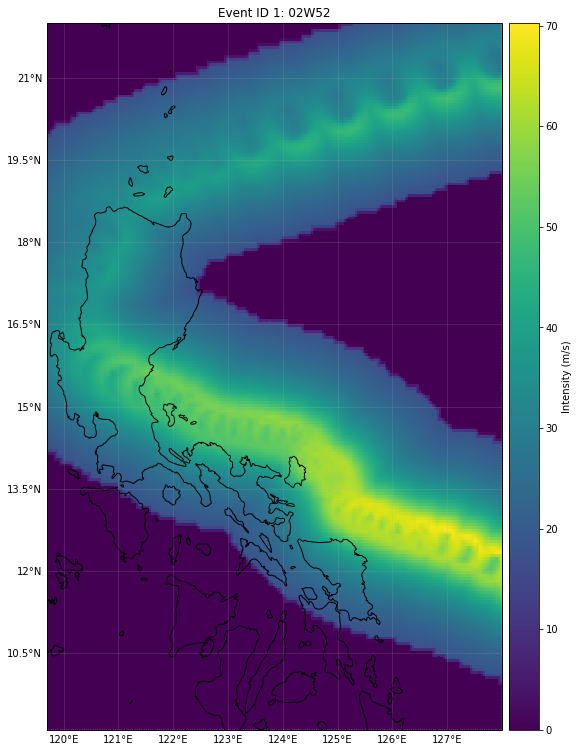

In [11]:
typhoon.plot_intensity(event=track.data[0].sid);

# Calculate wind field for all ensamble members

In [ ]:
#calculate wind field for each ensamble members 
list_intensity=[]
distan_track=[]
for tr in fcast.data:
    print(tr.sid)
    tr_SURIGAE = TCTracks() 
    tc_SURIGAE = TropCyclone()
    tr_SURIGAE.data=[tr]
    tc_SURIGAE.set_from_tracks(tr_SURIGAE, cent, store_windfields=True)
    windfield=tc_SURIGAE.windfields
    nsteps = windfield[0].shape[0]
    centroid_id = np.tile(centroid_idx, nsteps)
    intensity_3d = windfield[0].toarray().reshape(nsteps, ncents, 2)
    intensity = np.linalg.norm(intensity_3d, axis=-1).ravel()
    
    timesteps = np.repeat(tr.time.values, ncents)
    timesteps = timesteps.reshape((nsteps, ncents)).ravel()
    inten_tr = pd.DataFrame({
        'centroid_id': centroid_id,
        'value': intensity,
        'timestamp': timesteps,
    })

    inten_tr = inten_tr[inten_tr.value > threshold]
    inten_tr['storm_id'] = tr.sid
    list_intensity.append(inten_tr)
    for index, row in df.iterrows():
        dist=np.min(np.sqrt(np.square(tr.lat.values-row['lat'])+np.square(tr.lon.values-row['lon'])))
        distan_track.append(dist*111)
        
df['dis_track']=distan_track
df_intensity = pd.concat(list_intensity)
df_intensity=df_intensity.set_index('centroid_id')

df2=df_intensity.join(df.set_index('centroid_id'), on='centroid_id')

In [ ]:
#import admn shape files
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat))
admin=gpd.read_file("./data/admin/phl_admin3_simpl2.shp")
join_left_df = sjoin(gdf, admin, how="left")
join_left_df=join_left_df.dropna()
join_left_df.head()

In [ ]:

join_left_df_=join_left_df[join_left_df['value'].gt(12)].groupby(['adm3_pcode','timestamp','storm_id'],as_index=False).agg({"value":['count', 'max'],'dis_track':'min'}) 
# rename columns
join_left_df_.columns = ["_".join(x) for x in join_left_df_.columns.ravel()]
df3=join_left_df_[(join_left_df_['storm_id_']=='02W52') & (join_left_df_['adm3_pcode_']=='PH021523000')]
df3=df3.set_index('timestamp_',drop=True)
df3['value_max'].plot()

In [ ]:
join_left_df_=join_left_df[join_left_df['value'].gt(12)].groupby(['adm3_pcode','storm_id'],as_index=False).agg({"value":['count', 'max'],'dis_track':'min'}) 

# rename columns
join_left_df_.columns = [x for x in ['adm3_pcode','storm_id','value_count','v_max','dis_track_min']]#join_left_df_.columns.ravel()]
join_left_df_.to_csv('/forecast/intensity.csv')